In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from typing import *
from numpy.typing import *

In [2]:
def split_image_into_blocks(image: ArrayLike, block_size: Any) -> ArrayLike:
    '''
    Split an image into smaller blocks of the specified block size. 
    The function takes an input image and a block size, which can be either an integer or a tuple of two integers representing the height and width of the blocks. 

    Args:
        - image: input image as a numpy array.
        - block_size: the size of the blocks, either an integer or a tuple of two integers representing the height and width of the blocks.

    Returns:
        - blocks: a numpy array containing the image divided into smaller blocks of the specified size.
    '''
    if isinstance(block_size,int):
        block_height =  block_width = block_size
    else : 
        assert len(block_size) == 2 
        block_height, block_width = block_size
    height, width = image.shape[:2]
    
    n_blocks_height = height // block_height
    n_blocks_width = width // block_width
    blocks = np.zeros((n_blocks_height, n_blocks_width, block_height, block_width), dtype=image.dtype)
    for i in range(n_blocks_height):
        for j in range(n_blocks_width):
            block = image[i*block_height:(i+1)*block_height, j*block_width:(j+1)*block_width]
            blocks[i, j] = block
    return blocks

In [3]:
def calculate_rate_distortion(residual_block):
    # Tính toán distortion bằng cách tính toán độ sai khác giữa hai mảng
    distortion = np.mean(np.square(residual_block.flatten()))

    return distortion   

In [4]:
def Vertical_mode(block):
    '''mode 0: vertical'''
    new_block = block.copy()
    for i in range(block.shape[1]):
        new_block[:, i] = block[0, i]
    
    return new_block, np.clip(block - new_block, 0, 255)
    

In [5]:
def Horizontal_mode(block):
    new_block = block.copy()
    for i in range(block.shape[0]):
        new_block[i, :] = block[i, 0]
    
    return new_block, np.clip(block - new_block, 0, 255)

In [6]:
def DC_mode(block):
    # Tính trung bình các giá trị trong block
    dc_value = np.mean(block)

    # Tạo block dự đoán DC với giá trị trung bình dc_value
    predicted_block = np.full_like(block, dc_value)

    # Trả về block dự đoán
    return predicted_block, np.clip(block - predicted_block, 0, 255)

In [7]:
def intra_coding(img, block_size = 4):
    if isinstance(block_size,int):
        block_height =  block_width = block_size
    else : 
        assert len(block_size) == 2 
        block_height, block_width = block_size
    blocks = split_image_into_blocks(img, block_size)
    residual = np.zeros_like(img)
    intra_img = np.zeros_like(img)
    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            mb_block  = blocks[i,j]
            V_intra_block, V_residual_block = Vertical_mode(mb_block)
            V_rate_distortion = calculate_rate_distortion(mb_block, V_intra_block)
            
            H_intra_block, H_residual_block = Horizontal_mode(mb_block)
            H_rate_distortion = calculate_rate_distortion(mb_block, H_intra_block)
            
            DC_intra_block, DC_residual_block = DC_mode(mb_block)
            DC_rate_distortion = calculate_rate_distortion(mb_block, DC_intra_block)
            
            
            residual_block = [
                V_residual_block, H_residual_block, DC_residual_block
            ]
            
            intra_block = [
                V_intra_block, H_intra_block, DC_intra_block
            ]
            
            rate_distortion = np.array(
                [V_rate_distortion, H_rate_distortion, DC_rate_distortion]
            )
            
            indx = np.where(rate_distortion == np.min(rate_distortion))[0][0]
            
            
            
            residual[i * block_height : (i + 1)*block_height, j * block_width : (j + 1)* block_width] = residual_block[indx]
            intra_img[i * block_height : (i + 1)*block_height, j * block_width : (j + 1)* block_width] = intra_block[indx]
    return intra_img, residual

In [8]:
def intra_coding(img, block_size = 4):
    if isinstance(block_size,int):
        block_height =  block_width = block_size
    else : 
        assert len(block_size) == 2 
        block_height, block_width = block_size
    blocks = split_image_into_blocks(img, block_size)
    residual = np.zeros_like(img)
    intra_img = np.zeros_like(img)
    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            mb_block  = blocks[i,j]
            intra_block, residual_block = Vertical_mode(mb_block)
            
            residual[i * block_height : (i + 1)*block_height, j * block_width : (j + 1)* block_width] = residual_block
            intra_img[i * block_height : (i + 1)*block_height, j * block_width : (j + 1)* block_width] = intra_block
    return intra_img, residual

(-0.5, 1283.5, 719.5, -0.5)

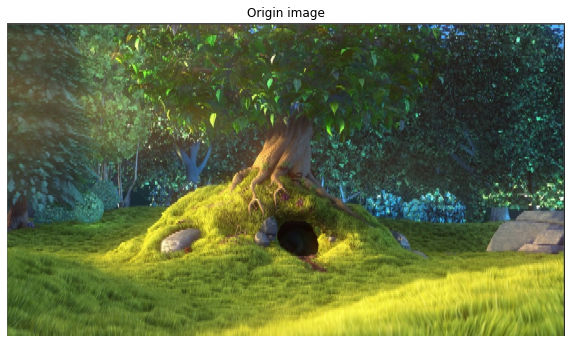

In [9]:
bgr_img = cv.imread('img.jpg')
bgr_img = cv.resize(bgr_img, (1284, 720))
b_img, g_img, r_img = cv.split(bgr_img)

intra_b_img, b_residual = intra_coding(b_img, 4)
intra_r_img, r_residual = intra_coding(r_img, 4)
intra_g_img, g_residual = intra_coding(g_img, 4)

intra_img = cv.merge([intra_r_img, intra_g_img, intra_b_img])
residual = cv.merge([r_residual, g_residual, b_residual])

plt.figure(figsize=(10,8))
rgb_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)
plt.imshow(intra_img)
plt.title('Origin image')
plt.axis('off')

(-0.5, 1283.5, 719.5, -0.5)

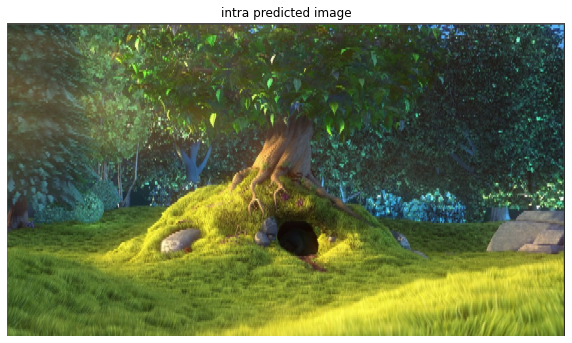

In [10]:
plt.figure(figsize=(10,8))
plt.imshow(intra_img)
plt.title('intra predicted image')
plt.axis('off')

(-0.5, 1283.5, 719.5, -0.5)

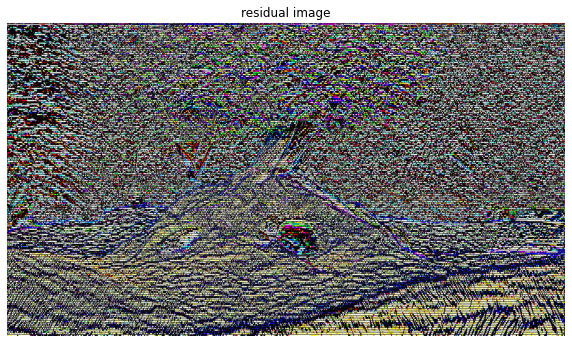

In [11]:
plt.figure(figsize=(10,8))
plt.imshow(residual)
plt.title('residual image')
plt.axis('off')

(-0.5, 1283.5, 719.5, -0.5)

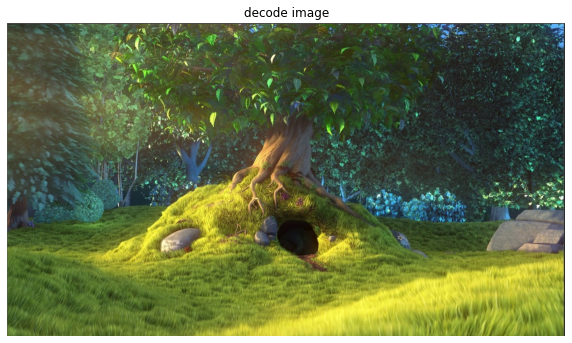

In [12]:
plt.figure(figsize=(10,8))
plt.imshow(intra_img + residual)
plt.title('decode image')
plt.axis('off')

In [13]:
intra_img.transpose(2,0,1)

array([[[ 94,  73,  79, ...,  84,  66,  71],
        [ 94,  73,  79, ...,  84,  66,  71],
        [ 94,  73,  79, ...,  84,  66,  71],
        ...,
        [ 84,  95, 100, ...,  89,  35,  40],
        [ 84,  95, 100, ...,  89,  35,  40],
        [ 84,  95, 100, ...,  89,  35,  40]],

       [[ 90,  69,  76, ...,  98,  65,  64],
        [ 90,  69,  76, ...,  98,  65,  64],
        [ 90,  69,  76, ...,  98,  65,  64],
        ...,
        [ 99, 113, 123, ...,  99,  38,  41],
        [ 99, 113, 123, ...,  99,  38,  41],
        [ 99, 113, 123, ...,  99,  38,  41]],

       [[ 87,  66,  71, ..., 107,  60,  48],
        [ 87,  66,  71, ..., 107,  60,  48],
        [ 87,  66,  71, ..., 107,  60,  48],
        ...,
        [ 60,  63,  55, ...,  65,  29,  45],
        [ 60,  63,  55, ...,  65,  29,  45],
        [ 60,  63,  55, ...,  65,  29,  45]]], dtype=uint8)